In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from pathlib import Path

from gensim.models.doc2vec import Doc2Vec
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.autolayout"] = True

In [2]:
data_dir = Path(Path.cwd().parent, 'data/interim')
models_dir = Path(Path.cwd().parent, 'models')
evals_dir = Path(data_dir, 'evals_4')
labels_dir = Path(data_dir, 'labels_2')
models_dir = Path(Path.cwd().parent, 'models')
datasets_order = {
    'chains_eq_2': 0,
    'chains_eq_3': 1,
    'chains_ge_4_lt_10': 2,
    'chains_ge_10': 3}

datasets_names = {
    'chains_eq_2': r'CL $= 2$',
    'chains_eq_3': r'CL $= 3$',
    'chains_ge_4_lt_10': r'10 $>$ CL $\geq$ 4',
    'chains_ge_10': r'CL $\geq$ 10'}

sizes = {}
for path in Path(models_dir).glob('d2v*.model'):
    size = len(Doc2Vec.load(str(path)).dv.vectors)
    name = '_'.join(path.stem.split('_')[1:])
    sizes[name] = size

In [3]:
[ev for ev in evals_dir.iterdir()]

[PosixPath('/home/miguel/Projects/tfm-nlp/data/interim/evals_4/eval_km_1665321770.csv'),
 PosixPath('/home/miguel/Projects/tfm-nlp/data/interim/evals_4/eval_dbscan_1665350029.csv'),
 PosixPath('/home/miguel/Projects/tfm-nlp/data/interim/evals_4/eval_dbscan_1665350210.csv'),
 PosixPath('/home/miguel/Projects/tfm-nlp/data/interim/evals_4/eval_dbscan_1665349954.csv'),
 PosixPath('/home/miguel/Projects/tfm-nlp/data/interim/evals_4/eval_dbscan_1665347108.csv'),
 PosixPath('/home/miguel/Projects/tfm-nlp/data/interim/evals_4/eval_dbscan_1665347169.csv'),
 PosixPath('/home/miguel/Projects/tfm-nlp/data/interim/evals_4/eval_dbscan_1665349877.csv'),
 PosixPath('/home/miguel/Projects/tfm-nlp/data/interim/evals_4/eval_dbscan_1665347374.csv'),
 PosixPath('/home/miguel/Projects/tfm-nlp/data/interim/evals_4/eval_dbscan_1665349002.csv'),
 PosixPath('/home/miguel/Projects/tfm-nlp/data/interim/evals_4/eval_dbscan_1665350824.csv'),
 PosixPath('/home/miguel/Projects/tfm-nlp/data/interim/evals_4/eval_dbscan

In [4]:
df_kmeans = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_km*.csv')], ignore_index=True)
df_kmeans['dimensions'] = df_kmeans['dataset'].apply(lambda s: s.split('_')[-1])
df_kmeans['dataset'] = df_kmeans['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_kmeans['order'] = df_kmeans['dataset'].map(datasets_order)
df_kmeans['name'] = df_kmeans['dataset'].map(datasets_names)
df_kmeans = df_kmeans.sort_values('order')
df_kmeans['k_noise'] = df_kmeans['n_clusters'].astype(int)
df_kmeans['method'] = 'KMeans'

df_dbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_dbscan*.csv')], ignore_index=True)
df_dbscan['size'] = df_dbscan['dataset'].map(sizes)
df_dbscan['prop_noise'] = df_dbscan['n_noise']/df_dbscan['size']
df_dbscan['dimensions'] = df_dbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_dbscan['dataset'] = df_dbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_dbscan['order'] = df_dbscan['dataset'].map(datasets_order)
df_dbscan['name'] = df_dbscan['dataset'].map(datasets_names)
df_dbscan = df_dbscan.sort_values('order')
df_dbscan['k_noise'] = df_dbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_dbscan['method'] = 'DBSCAN'

df_hdbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('*_hdbscan*.csv')], ignore_index=True)
df_hdbscan['size'] = df_hdbscan['dataset'].map(sizes)
df_hdbscan['prop_noise'] = df_hdbscan['n_noise']/df_hdbscan['size']
df_hdbscan['dimensions'] = df_hdbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_hdbscan['dataset'] = df_hdbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_hdbscan['order'] = df_hdbscan['dataset'].map(datasets_order)
df_hdbscan['name'] = df_hdbscan['dataset'].map(datasets_names)
df_hdbscan = df_hdbscan.sort_values('order')
df_hdbscan['k_noise'] = df_hdbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_hdbscan['method'] = 'HDBSCAN'
datasets = df_dbscan.sort_values(by='order')['dataset'].unique()

eval_scores = ['sl_score', 'ch_score', 'db_score', 'entropy']

In [6]:
df_dbscan.dropna()

,distance,dataset,epsilon,min_pts,nn,n_clusters,sl_score,ch_score,db_score,entropy,n_noise,size,prop_noise,dimensions,order,name,k_noise,method
6769,l2,chains_eq_2,13.833861,9,21.0,2,0.435467,34.657777,0.982132,0.003534,1375.0,23841,0.057674,50,0,CL $= 2$,2 (0.058),DBSCAN
6768,l2,chains_eq_2,13.833861,8,21.0,3,0.372546,29.771012,0.983228,0.006713,1356.0,23841,0.056877,50,0,CL $= 2$,3 (0.057),DBSCAN
6767,l2,chains_eq_2,13.833861,7,21.0,3,0.372291,29.734687,0.983509,0.006710,1346.0,23841,0.056457,50,0,CL $= 2$,3 (0.056),DBSCAN
6766,l2,chains_eq_2,13.833861,6,21.0,3,0.371880,29.676126,0.983963,0.006705,1329.0,23841,0.055744,50,0,CL $= 2$,3 (0.056),DBSCAN
6765,l2,chains_eq_2,13.833861,5,21.0,3,0.371351,29.597753,0.984552,0.006700,1307.0,23841,0.054822,50,0,CL $= 2$,3 (0.055),DBSCAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,l2,chains_ge_10,5.419302,2,25.0,2,0.370682,7.200524,0.783066,0.003375,66.0,5324,0.012397,300,3,CL $\geq$ 10,2 (0.012),DBSCAN
1526,l2,chains_ge_10,5.415919,2,24.0,2,0.370682,7.200524,0.783066,0.003375,66.0,5324,0.012397,300,3,CL $\geq$ 10,2 (0.012),DBSCAN
1470,l2,chains_ge_10,5.397477,2,20.0,2,0.371083,7.212328,0.782653,0.003381,75.0,5324,0.014087,300,3,CL $\geq$ 10,2 (0.014),DBSCAN
1498,l2,chains_ge_10,5.406634,2,22.0,2,0.370911,7.207274,0.782827,0.003378,71.0,5324,0.013336,300,3,CL $\geq$ 10,2 (0.013),DBSCAN


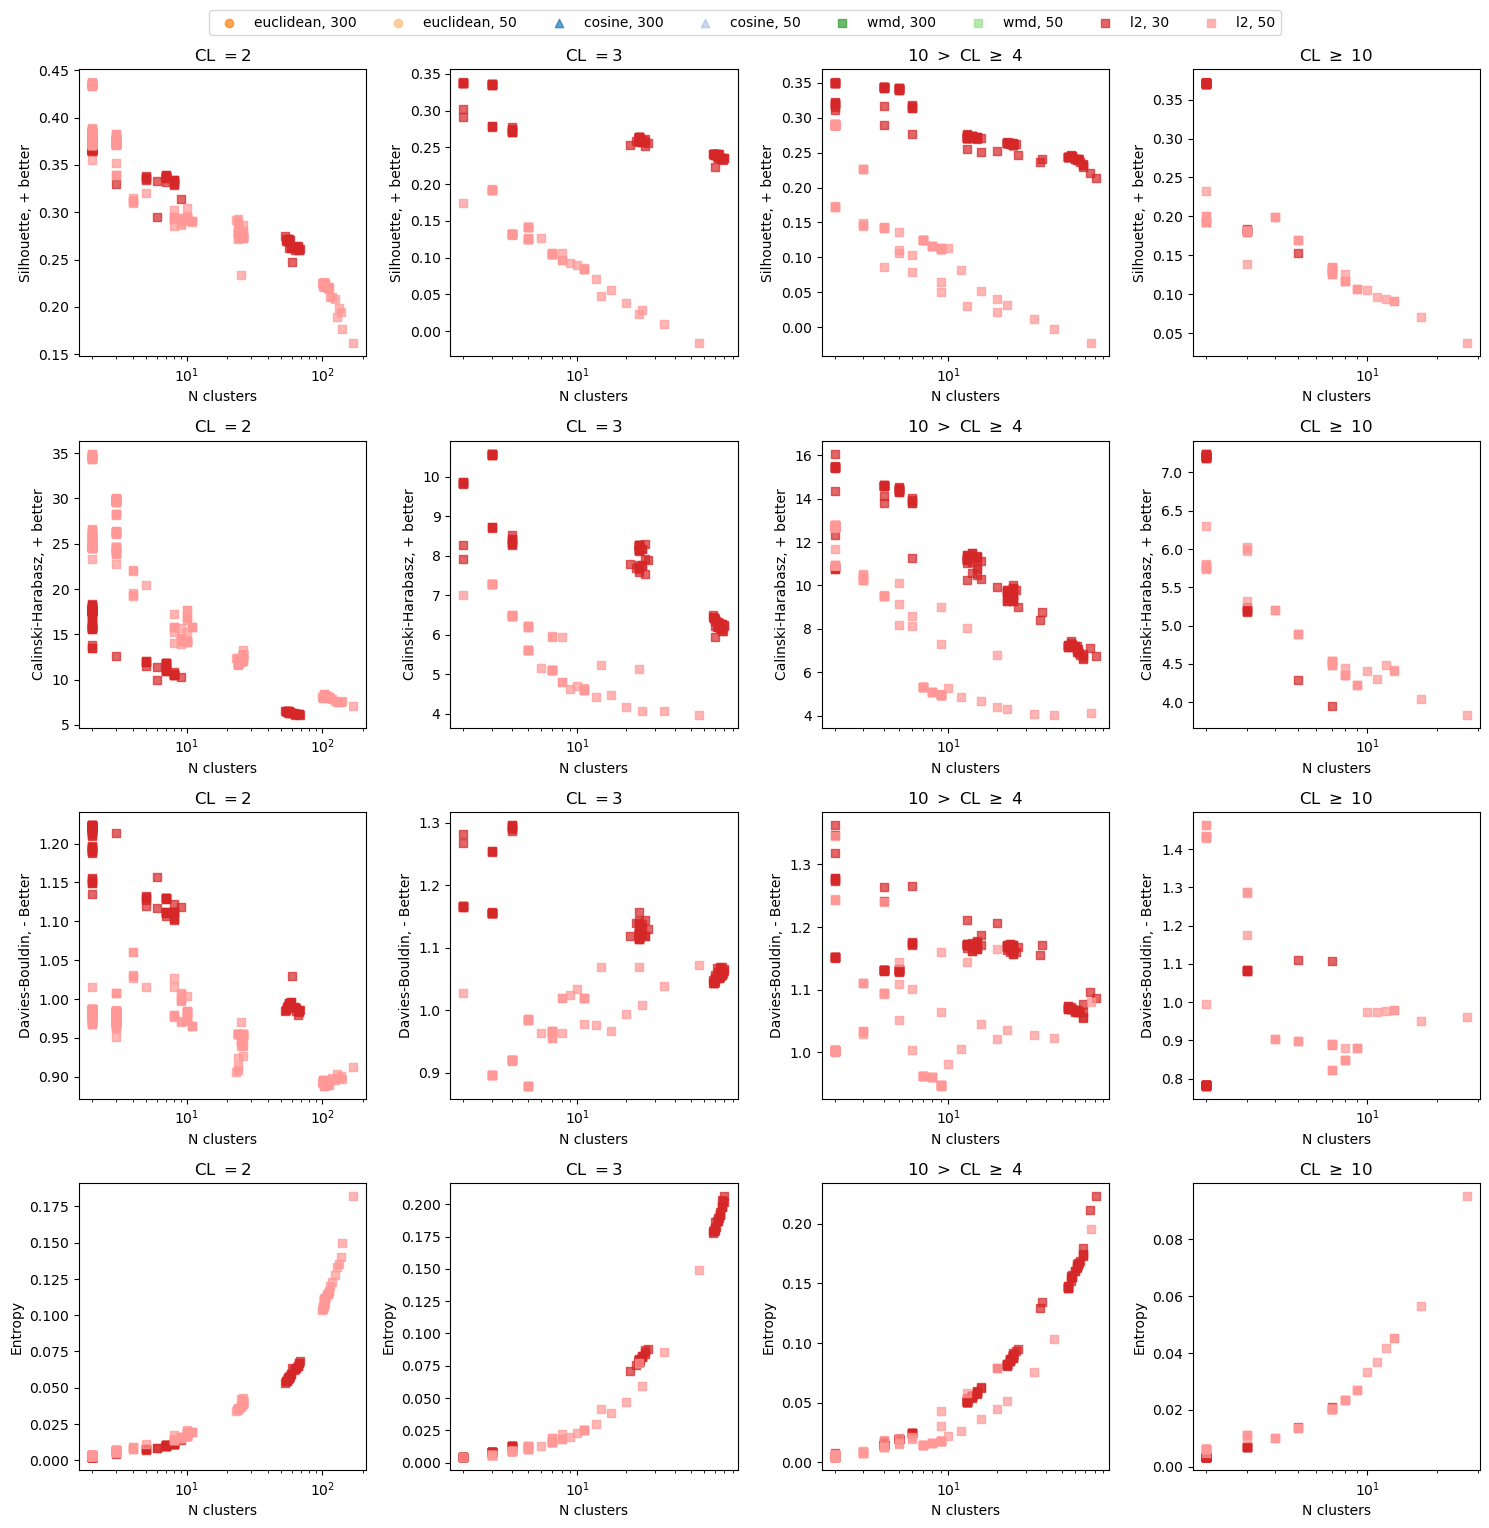

In [16]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_dbscan.sort_values(by='order')['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy']
ncols = len(datasets)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna().loc[df_dbscan['dataset']==datasets[col],:].sort_values('n_clusters')
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='s', alpha=0.7)
        axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel('N clusters')
        axes[row][col].set_ylabel(score_names[row])
        axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
# fig.savefig(Path('../img/scores_dbscan.png'), bbox_inches='tight')
plt.show()

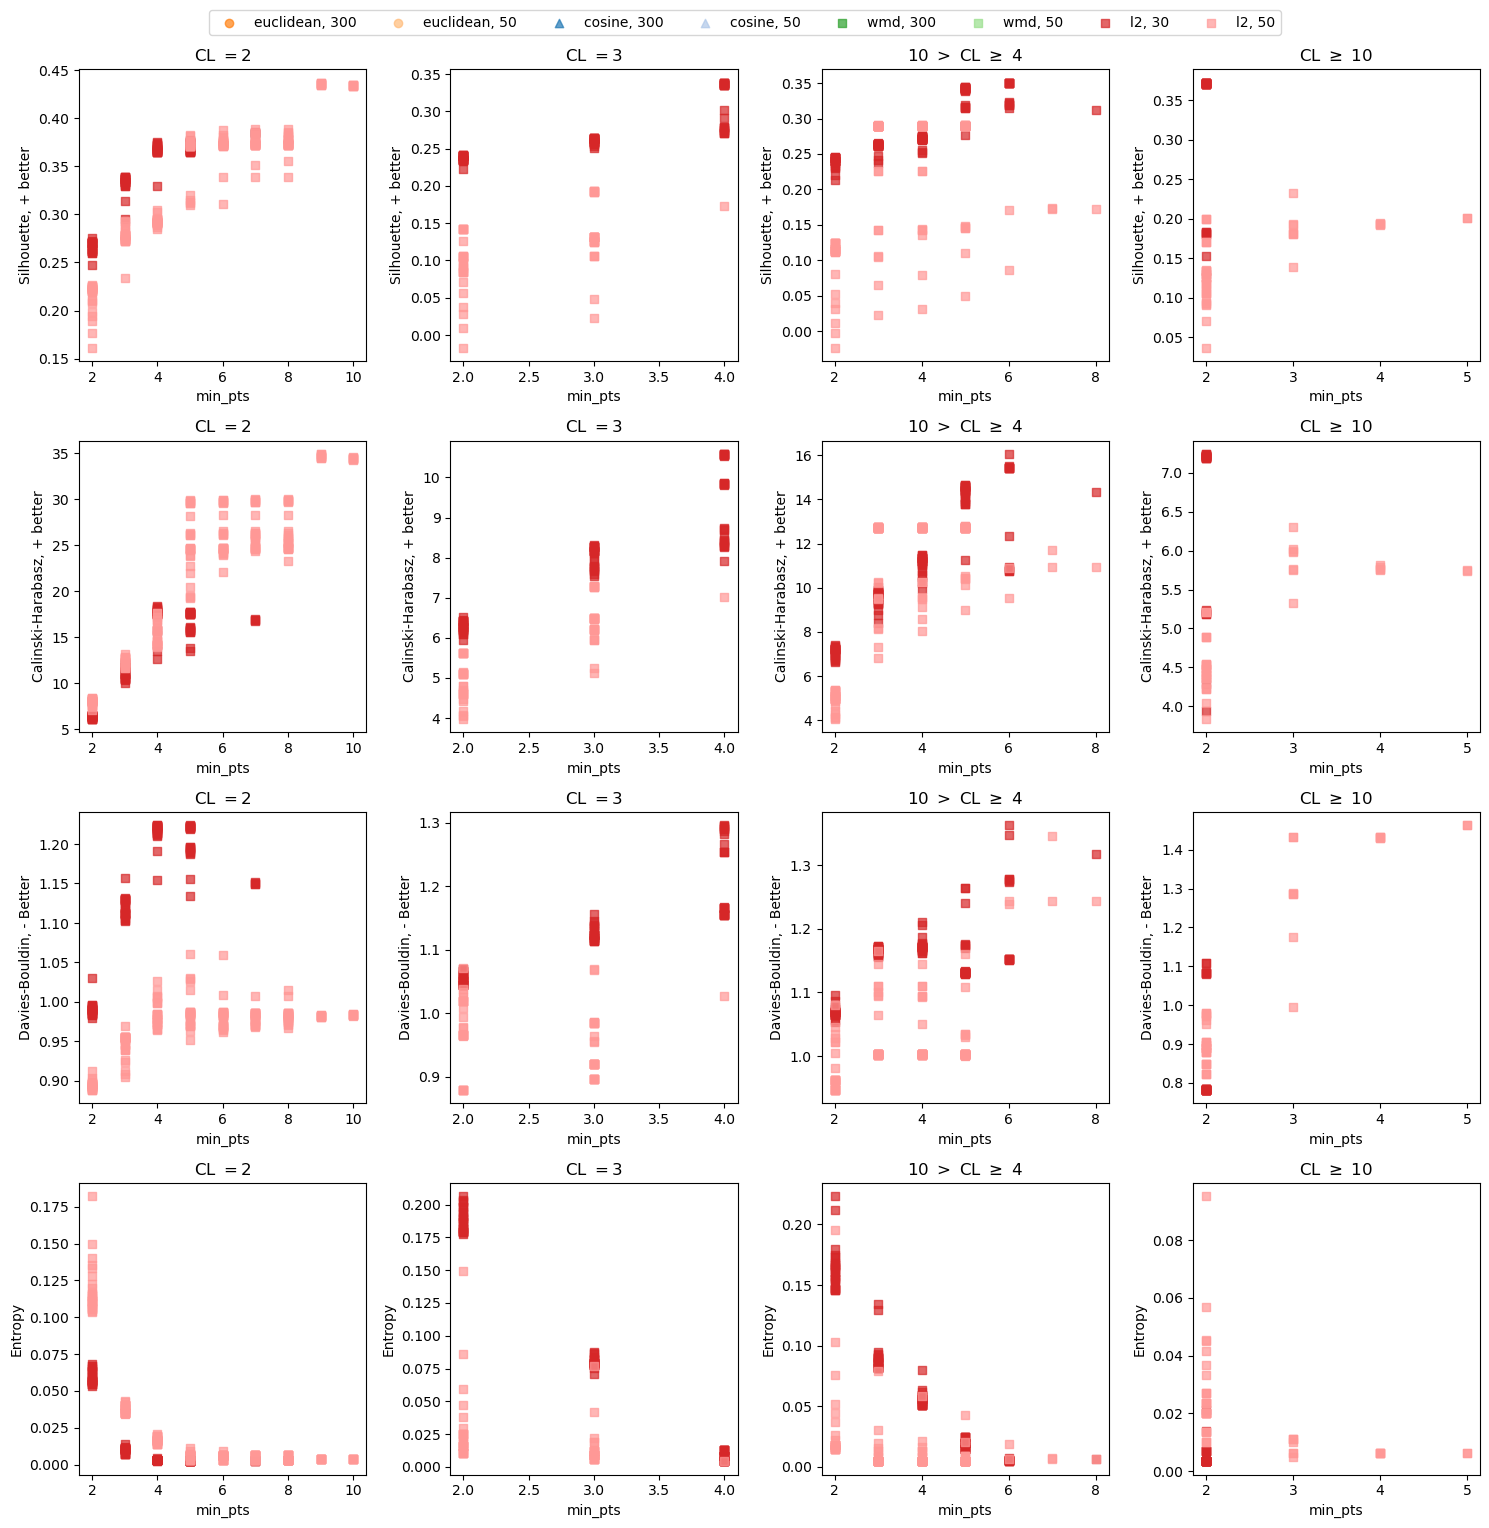

In [18]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_dbscan.sort_values(by='order')['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy']
ncols = len(datasets)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

param = 'min_pts'

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna().loc[df_dbscan['dataset']==datasets[col],:].sort_values(param)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='s', alpha=0.7)
        axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel('min_pts')
        axes[row][col].set_ylabel(score_names[row])
        # axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
# fig.savefig(Path('../img/scores_dbscan.png'), bbox_inches='tight')
plt.show()

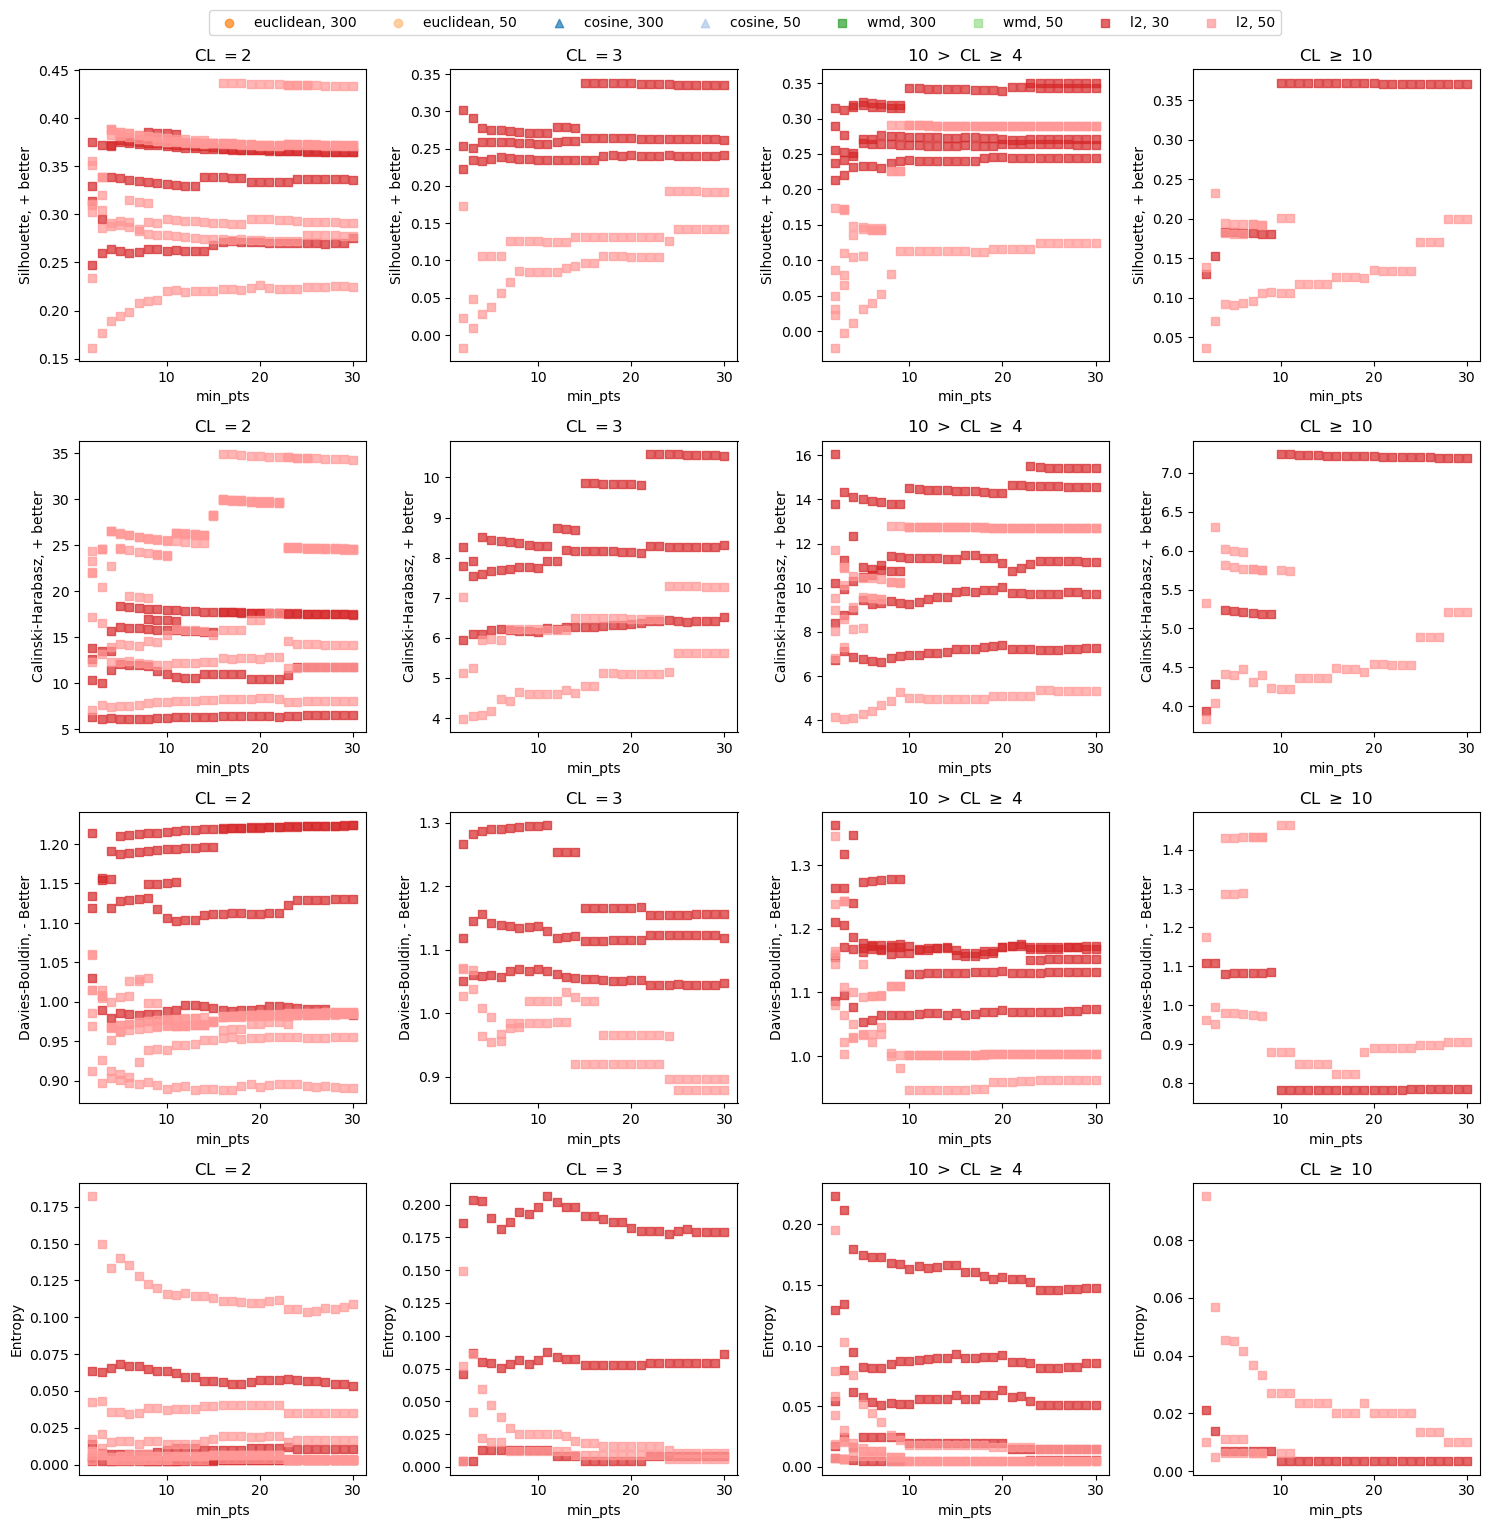

In [15]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_dbscan.sort_values(by='order')['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy']
ncols = len(datasets)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

param = 'nn'

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna().loc[df_dbscan['dataset']==datasets[col],:].sort_values(param)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='s', alpha=0.7)
        axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel('min_pts')
        axes[row][col].set_ylabel(score_names[row])
        # axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
# fig.savefig(Path('../img/scores_dbscan.png'), bbox_inches='tight')
plt.show()

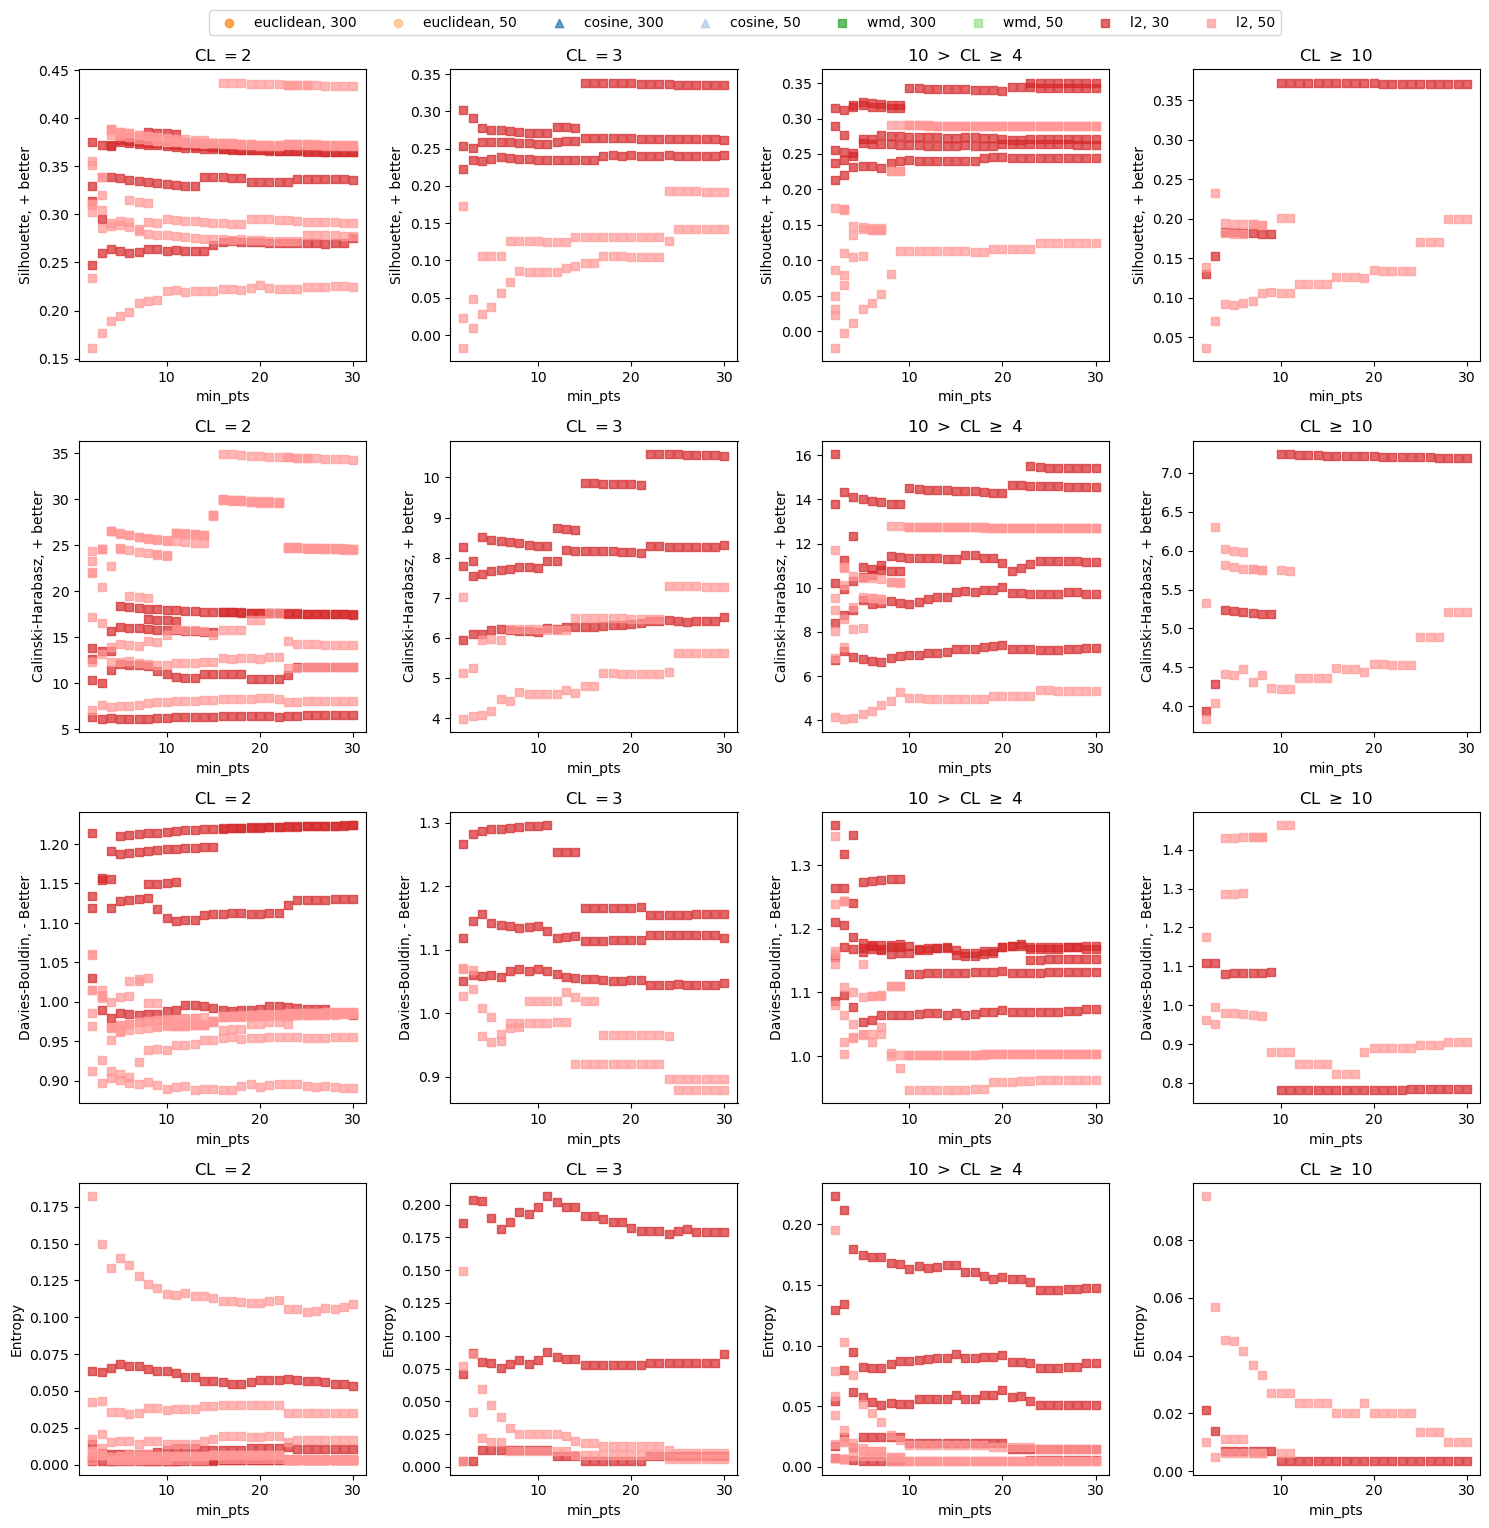

In [14]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_dbscan.sort_values(by='order')['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy']
ncols = len(datasets)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

param = 'nn'

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.loc[df_dbscan['dataset']==datasets[col],:].sort_values(param)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=param, y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='s', alpha=0.7)
        axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel('min_pts')
        axes[row][col].set_ylabel(score_names[row])
        # axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
# fig.savefig(Path('../img/scores_dbscan.png'), bbox_inches='tight')
plt.show()